## Object detection metrics and errors 
Object detection and instance segmentation primarily use one metric to judge performance: `mean Average Precision (mAP )`. How do we interpret it? For a metric like `accuracy` we know that 90% means that the model is wrong `10%` of the time. we will see the following things in this blog.
- what does a mAP of `63.2%` actually mean? 
- why do we use `mAP` as a metric in object detection? 
- what kind of errors are associated with your model which is hampering your overall score?
    - A `false positive` can be a 
        - duplicate detection
        - misclassification
        - mislocalization
        - confusion with background
        - both a misclassification and mislocalization.
    - a false negative could be a 
        - completely missed ground truth, 
        - potentially correct prediction could have just been misclassified or mislocalized. 

There are 3 places our detector can affect mAP 
- outputting false positives during the matching step, 
- not outputting true positives (i.e., false negatives) for computing recall, 
- having incorrect calibration (i.e., outputting a higher confidence for a false positive then a true positive).

The difficulty of the code has increased because
- we have multiple classes 
- we have multiple thresholds 
- we have to do for both mask and bbox
- we have multiple metrics [small, medium, large, mAR, mAP]


we will simplify the code by 
- using one single threshold (mAP 50)
- only bbox 
- only mAP 

First lets calculate `mAP` of the model. we will First use `torchvision` retinanet on COCO dataset

In [1]:
import numpy as np 
import pandas as pd
import torchvision
import torch
from PIL import Image
from pathlib import Path
import pandas as pd
from pycocotools.coco import COCO
from torchvision.ops.boxes import _box_xywh_to_xyxy as xywh_to_xyxy
from typing import Union, Optional, List
from tqdm import tqdm
from pydantic import BaseModel


import matplotlib.pyplot as plt
%matplotlib inline 

plt.style.use("bmh")

> Load the model.

In [2]:
weights = torchvision.models.detection.retinanet.RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1
model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights = weights, num_classes=91)
model.eval()
preprocess= weights.DEFAULT.transforms()

> Load the data

In [158]:
class Bbox(BaseModel):
    x1: float 
    y1: float 
    x2: float 
    y2: float 
    
    @property
    def xyxy(self):
        return np.asarray([self.x1, self.y1, self.x2, self.y2])
    
    @property
    def xywh(self):
        x, y = self.x1, self.y1
        h = self.y2-self.y1
        w = self.x2-self.x1
        return np.asarray([x, y, w, h])
    


class AnnotBbox(BaseModel):
    img_id: int
    category_id: int
    bbox: Bbox
    conf: Optional[float]
    iou: Optional[float]
    tp_fp_fn: Optional[str]
    area: Optional[float]
    is_crowd: Optional[int]
    chars: Optional[List[str]]
        
        
class AnnotImg(BaseModel):
    img_id: int 
    gt_box: List[AnnotBbox] = []
    pred_box: List[AnnotBbox] = []

In [159]:
class COCODataset:
    def __init__(self, img_root, annot_loc, transforms=None):
        self.coco = COCO(annot_loc)
        self.img_root = Path(img_root)
        self.img_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_meta = self.coco.imgs[img_id]
        img_loc = self.img_root / img_meta["file_name"]
        img = Image.open(img_loc)
        
        ## Load annotations 
        annot_ids = self.coco.getAnnIds(imgIds=[img_id])
        annots = self.coco.loadAnns(ids = annot_ids)
        annot = []
        for ann in annots:
            box = ann["bbox"]
            box = Bbox(x1=box[0], y1=box[1], x2=box[2]+box[0], y2=box[3]+box[1])
            tt = AnnotBbox(img_id=img_id, category_id=ann["category_id"], bbox=box)
            annot.append(tt)
        annot = AnnotImg(img_id=img_id, gt_box=annot)
        
        if self.transforms is not None:
            return self.transforms(img).unsqueeze(0), annot
        return img, annot
    
    def __len__(self):
        return len(self.coco.imgs) 

In [160]:
annot_loc = "data/coco/annotations/instances_val2017.json"
img_root = "data/coco/val2017/"
ds = COCODataset(img_root, annot_loc=annot_loc, transforms=preprocess)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


> Load a single image with its annotations.

In [161]:
img, annots = ds[10]
img_id = annots.img_id
print(img_id, img.shape, len(annots.gt_box))

296649 torch.Size([1, 3, 427, 640]) 26


> Generate predictions

- This model uses an nms threshold of 0.5. check `model.nms_thresh`
- The output is a dict with boxes, scores, labels as keys. 

In [162]:
with torch.no_grad():
    output = model(img)[0]
output.keys()

dict_keys(['boxes', 'scores', 'labels'])

In [163]:
def convert_outputs_to_annotschema(output, img_id):
    preds = []
    for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
        tt = AnnotBbox(img_id=img_id, bbox=Bbox(x1=box[0], y1=box[1], x2=box[2], y2=box[3]), conf=round(float(score), 3), category_id=int(label))
        preds.append(tt)
    return preds
annots.pred_box = convert_outputs_to_annotschema(output, img_id)
len(annots.pred_box)

182

In [164]:
annots.pred_box[0]

AnnotBbox(img_id=296649, category_id=4, bbox=Bbox(x1=262.2518005371094, y1=329.0896911621094, x2=427.1844177246094, y2=427.0000305175781), conf=0.879, iou=None, tp_fp_fn=None, area=None, is_crowd=None, chars=None)

## check FP's, FN's and TP's for each bbox.
Each bbox (both gt and pred), we need to assign TP, FP or FN label. We will do this at 3 levels
- single image single class `SISCE` 
- single image all classes `SIE`
- Dataset level `DE`
where `E` stands for Error. 

### SISCE: single image, single class
- this works on single image and for a single class.
- It calculates IOU between gt and pred of the same class bboxes. 
- For gt, it assigns TP or FN label
- For preds, it assigns TP or FP label.
- creats gt and preds df with scores.

> for each predicted bounding box we need to see if it has a correct match or not. we will do this for each class in each image first. 

> find iou between gt and pred and assign each pred with a gt using max_iou

In [175]:
class AssignTPFPTN:
    def __init__(self, iou_thr, iou_type="iou", allow_duplicates=False):
        self.iou_thr = iou_thr
        self.iou_type = iou_type
        self.allow_duplicates = allow_duplicates 
        self.all_matches = np.empty((0, 3))
    
    def implement_iou(self, gt: List[AnnotBbox], pred: List[AnnotBbox]):
        gt = np.vstack([i.bbox.xyxy for i in gt])
        pred = np.vstack([i.bbox.xyxy for i in pred])
        
        if self.iou_type == "iou":
            return torchvision.ops.box_iou(torch.Tensor(gt).float(), torch.Tensor(pred).float()).numpy()
        else:
            raise NotImplementedError(f"iou_type: {self.iou_type} is not implemented")
    
    def match_idx_for_each_gt(self, gt: List[AnnotBbox], pred: List[AnnotBbox]):
        # Get one unique match for each gt. 
        self.all_matches = np.empty((0, 3))
        run = self._base_checks(gt, pred)
        if run:
            iou = self.implement_iou(gt, pred)
            widx = np.where(iou > self.iou_thr)
            all_matches = np.asarray([(widx[0][i], widx[1][i], iou[widx[0][i], widx[1][i]]) for i in range(widx[0].shape[0])])

            # if there is match
            if all_matches.shape[0] > 0:  
                # sort by prob
                all_matches = all_matches[all_matches[:, 2].argsort()[::-1]] 
                #if there one prediction for 2 gts. Remove the 1 with low conf
                all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]] 
                # sort again via prob score. 
                all_matches = all_matches[all_matches[:, 2].argsort()[::-1]] 
                # if a gt has two predictions, remove the 1 with low confidence.
                # below code should not run when we allow duplicate for each gt. 
                if not self.allow_duplicates:
                    all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]] 
            self.all_matches = all_matches 
    
    def _base_checks(self, gt, pred):
        if (len(gt) == 0) or (len(pred) == 0):
            return False
        if (len(gt) == 0) and (len(pred) ==0):
            return False 
        return True
    
    def assign_label_to_gt(self, gt):
        if len(gt) == 0:
            return gt
        pos_idx = np.unique(self.all_matches[:, 0]).astype(int)
        for g in gt:
            g.tp_fp_fn = "FN"
                
        for pos in pos_idx:
            gt[pos].tp_fp_fn = "TP"
        return gt
    
    def assign_label_to_pred(self, pred):
        if len(pred) == 0:
            return pred 
        pos_idx = self.all_matches[:, 1].astype(int)
        iou_score = self.all_matches[:, 1]
        
        for g in pred:
            g.tp_fp_fn = "FN"
            g.iou = 0
        
        for num, pos in enumerate(pos_idx):
            pred[pos].tp_fp_fn = "TP"
            pred[pos].iou = iou_score[num]
        return pred
    
    
    def __call__(self, img: AnnotImg, cat_id=1):
        self.all_matches = np.empty((0, 3))
        gt = [i for i in img.gt_box if i.category_id == cat_id]
        pred = [i for i in img.pred_box if i.category_id == cat_id]
        self.match_idx_for_each_gt(gt, pred)
        gt = self.assign_label_to_gt(gt)
        pred = self.assign_label_to_pred(pred)
        new_img = AnnotImg(img_id=img.img_id, gt_box=gt, pred_box=pred)
        return new_img
    
#     def create_df(self, gt, pred, scores):
#         gt = self.forward(gt, pred)
#         gt_df = self.to_df(gt, gt_labels)
#         pred_df = self.to_df(pred, pred_labels)
#         pred_df["conf_scores"] = scores
#         pred_df['iou_scores'] = iou_scores 
#         return gt_df, pred_df
    
    
#     def to_df(self, c1, c1_tt):
#         if isinstance(c1, torch.Tensor):
#             c1 = c1.numpy()
#         df = pd.DataFrame(c1)
#         df.columns = ["x1", "y1", "x2", "y2"]
#         df["TP_FP_FN"] = c1_tt
#         return df   

In [176]:
tt = AssignTPFPTN(0.3, allow_duplicates=False)

> initally all matches are zero

In [177]:
tt.all_matches

array([], shape=(0, 3), dtype=float64)

> then we create matches - allow_duplicates is optional , when true, each gt can have multiple predictions. 

In [178]:
tt.match_idx_for_each_gt([], [])
tt.all_matches

array([], shape=(0, 3), dtype=float64)

In [179]:
req_gt_boxes = [i for i in annots.gt_box if i.category_id == 1]
req_pred_boxes = [i for i in annots.pred_box if i.category_id == 1]
len(req_gt_boxes), len(req_pred_boxes)

(13, 57)

In [180]:
tt.match_idx_for_each_gt(req_gt_boxes, req_pred_boxes)
tt.all_matches

array([[ 0.        ,  1.        ,  0.76189595],
       [ 1.        ,  4.        ,  0.84801722],
       [ 2.        ,  0.        ,  0.92562371],
       [ 3.        ,  2.        ,  0.88024783],
       [ 4.        ,  8.        ,  0.63157827],
       [ 5.        ,  6.        ,  0.88249034],
       [ 6.        , 10.        ,  0.8462857 ],
       [ 7.        , 11.        ,  0.87101638],
       [ 8.        , 13.        ,  0.77039939],
       [ 9.        , 17.        ,  0.84931129],
       [10.        ,  7.        ,  0.89239097],
       [11.        ,  3.        ,  0.85208642],
       [12.        ,  5.        ,  0.65539688]])

> Now assign labels to each gt. 

In [181]:
gt_label = tt.assign_label_to_gt(req_gt_boxes)
len(gt_label)

13

> Now assign labels to each pred. we can also get iou_scores. 

In [182]:
pred_label = tt.assign_label_to_pred(req_pred_boxes)
len(pred_label)

57

In [183]:
annots_cat_1 = tt(annots, cat_id=1)
len(annots_cat_1.pred_box), len(annots_cat_1.gt_box)

(57, 13)

## Single class multiple images - mAP score. 
- mAP & mAR score can be aggregated for mulitple iou scores. 
- we should be able to subset bboxes (gt) based on small, medium, large. 

## TODO: Lets use pydantic heavily in this. it will allow for better readability
- we should store everything using pydantic.

## this comes for per image at @iou_score
- total true pos [per image]
- total false pos [per image]
- total false neg [per image]

In [248]:
def compute_ap(recall, precision):
    """Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list)
    # Returns
        Average precision, precision curve, recall curve
    """

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [recall[-1] + 0.01]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = "interp"  # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec


class mAP:
    def __init__(self, iou_type, allow_duplicates=False):
        self.iou_type = iou_type
        self.allow_duplicates = allow_duplicates
        self.raw: Dict[str, AnnotImg] = {}
        self.gt_sc: Optional[pd.DataFrame] = None 
        self.pred_sc: Optional[pd.DataFrame] = None
    
    def update(self, img: AnnotImg):
        # we need to predict and update the bboxes
        self.raw[img.img_id] = img
         
    
    def compute_map(self, cat_ids: List[int], topk: Optional[int]=None):
        # compute ap for each class and then average them to get mAP
        # top is used to take top N values if None, everything is used
        pass 
    
    def compute_ap_iou(self, iou_scores: List[float], cat_id: int,  topk: Optional[int]=None):
        # compute AP @ multiple_ious @cat_id
        aps = []
        for iou_score in iou_scores:
            self.compute_gt_pred_tpfpfn(iou_score, cat_id)
            print(self.pred_sc.shape, self.gt_sc.shape)
            ap, _ = self.compute_ap_iou_class(topk=topk)
            aps.append(ap)
        aps = np.asarray(aps)
        return np.mean(aps), aps
    
    
    def compute_ap_iou_class(self, topk: Optional[int]=None):
        # compute AP@iou for a cat_id
        if (self.gt_sc is None) or (self.pred_sc is None):
            raise ValueError("Please call `comput_gt_pred_tpfptn first")
        gt, pred = self.gt_sc, self.pred_sc
        total_gt = len(gt)
        if topk is not None:
            pred = pred.sort_values(["img_id", "conf"], ascending=False).reset_index(drop=True).groupby('img_id').head(topk)
        gt, pred = self.cal_pre_rec(gt, pred)
        ap, mpre, mrec = compute_ap(pred["recall"].values, pred["precision"].values)
        return ap, {"mpre": mpre, "mrec": mrec, "gt": gt, "pred": pred}
        
        
    @staticmethod
    def cal_pre_rec(gt, pred):
        total_gt = len(gt)
        pred = pred.sort_values("conf", ascending=False).reset_index(drop=True)
        pred["TP"] = pred["TP_FP_FN"].apply(lambda x: 1 if x == "TP" else 0)
        pred["FP"] = pred["TP_FP_FN"].apply(lambda x: 1 if x == "FP" else 0)
        pred["acc_tp"] = pred["TP"].cumsum()
        pred["acc_fp"] = pred["FP"].cumsum()
        pred["precision"] = pred["acc_tp"] / (pred["acc_tp"] + pred["acc_fp"] + 1e-16)
        pred["recall"] = pred_conf["acc_tp"] / (total_gt + 1e-16)
        pred["AvgFalsePosScan"] = pred_conf["acc_fp"] / (total_gt + 1e-16)
        return gt, pred
    
    
    def compute_gt_pred_tpfpfn(self, iou_score, cat_id):
        self.gt_sc = None 
        self.pred_sc = None 
        ttt = []
        tp_fp_fn = AssignTPFPTN(iou_score, self.iou_type, self.allow_duplicates)
        for img_id in self.raw.keys():
            each_img = self.raw[img_id]
            tt = tp_fp_fn(deepcopy(each_img), cat_id=cat_id)
            ttt.append(tt)
        gt_sc = pd.DataFrame([[i.img_id, i.tp_fp_fn] for img in ttt for i in img.gt_box])
        gt_sc.columns = ["img_id", "TP_FP_FN"]
        self.gt_sc = gt_sc
        
        #import pdb; pdb.set_trace()
        pred_sc = pd.DataFrame([[i.img_id, i.conf, i.tp_fp_fn] for img in ttt for i in img.pred_box])
        pred_sc.columns = ["img_id", "conf", "TP_FP_FN"]
        self.pred_sc = pred_sc
        
            
        
    def compute_mar(self, cat_ids: List[int], top: Optional[int]=None):
        # compute ar for each class and then average them to get mAR
        pass 
    
    def compute_ar_iou(self, iou_scores=List[float], top: Optional[int]=None):
        # compute AR @ multiple_ious 
        pass 
    
    
    def compute_ar_iou_class(self, iou_score, cat_id, top: Optional[int]=None):
        # compute AR@iou for a cat_id
        pass

In [195]:
allt = []
for d in tqdm(range(len(ds))):
    img, annots = ds[d]
    
    with torch.no_grad():
        output = model(img)[0]
        
    preds = convert_outputs_to_annotschema(output, annots.img_id)
    annots.pred_box = preds
    allt.append(annots)
    if d>5:
        break

  0%|                                                                                        | 6/5000 [01:24<19:34:16, 14.11s/it]


In [249]:
map_score = mAP("iou", False)

In [250]:
for tt in allt:
    map_score.update(tt)

In [251]:
map_score.compute_gt_pred_tpfpfn(0.5, 1)

In [252]:
map_score.gt_sc.shape, map_score.gt_sc.head()

((19, 2),
    img_id TP_FP_FN
 0  397133       TP
 1  397133       TP
 2  252219       TP
 3  252219       TP
 4  252219       TP)

In [253]:
map_score.pred_sc.shape, map_score.pred_sc.head()

((154, 3),
    img_id   conf TP_FP_FN
 0  397133  0.834       TP
 1  397133  0.662       TP
 2  397133  0.125       FN
 3  397133  0.115       FN
 4  397133  0.102       FN)

In [254]:
np.arange(0.5, 0.7, 0.05)

array([0.5 , 0.55, 0.6 , 0.65])

In [255]:
map_score.compute_ap_iou(iou_scores=np.arange(0.5, 0.8, 0.05).tolist(), cat_id=1)

(154, 3) (19, 2)
(154, 3) (19, 2)
(154, 3) (19, 2)
(154, 3) (19, 2)
(154, 3) (19, 2)
(154, 3) (19, 2)
(154, 3) (19, 2)


(0.9523684210526316,
 array([0.95236842, 0.95236842, 0.95236842, 0.95236842, 0.95236842,
        0.95236842, 0.95236842]))

In [30]:
ttt = []
for each_img in allt:
    print(each_img.img_id)
    tt = tp_fp_fn(deepcopy(each_img), cat_id=1)
    ttt.append(tt)

397133
37777
252219
87038
174482
403385
6818


In [40]:
gt_sc = sum([len(i.gt_box) for i in ttt])
gt_sc

19

In [47]:
gt_sc = pd.DataFrame([[i.tp_fp_fn] for img in ttt for i in img.pred_box])
gt_sc.columns = ["TP_FP_FN"]
gt_sc.head()

,TP_FP_FN
0,TP
1,TP
2,FN
3,FN
4,FN


In [34]:
[len(i.pred_box) for i in ttt]

[10, 4, 22, 100, 17, 0, 1]

In [42]:
pred_conf = pd.DataFrame([[i.conf, i.tp_fp_fn] for img in ttt for i in img.pred_box])
pred_conf.columns = ["conf", "TP_FP_FN"]
pred_conf = pred_conf.sort_values("conf", ascending=False).reset_index(drop=True)
pred_conf["TP"] = pred_conf["TP_FP_FN"].apply(lambda x: 1 if x == "TP" else 0)
pred_conf["FP"] = pred_conf["TP_FP_FN"].apply(lambda x: 1 if x == "FP" else 0)
pred_conf["acc_tp"] = pred_conf["TP"].cumsum()
pred_conf["acc_fp"] = pred_conf["FP"].cumsum()
pred_conf["precision"] = pred_conf["acc_tp"] / (pred_conf["acc_tp"] + pred_conf["acc_fp"] + 1e-16)
pred_conf["recall"] = pred_conf["acc_tp"] / (gt_sc + 1e-16)
pred_conf["AvgFalsePosScan"] = pred_conf["acc_fp"] / (gt_sc + 1e-16)
pred_conf.head()

,conf,TP_FP_FN,TP,FP,acc_tp,acc_fp,precision,recall,AvgFalsePosScan
36,0.949,TP,1,0,1,0,1.0,0.052632,0.0
14,0.929,TP,1,0,2,0,1.0,0.105263,0.0
15,0.921,TP,1,0,3,0,1.0,0.157895,0.0
16,0.915,TP,1,0,4,0,1.0,0.210526,0.0
37,0.876,TP,1,0,5,0,1.0,0.263158,0.0


In [45]:
ap, mpre, mrec = compute_ap(pred_conf["recall"].values, pred_conf["precision"].values)
ap

0.9523684210526315

In [15]:
class SIE:
    # Single image error
    def __init__(self, iou_thr):
        self.sisce = SISCE(iou_thr=iou_thr)
    
    def forward_class(self, 
                      gts: torch.Tensor, 
                      gt_labels: torch.Tensor, 
                      preds: torch.Tensor, 
                      pred_scores: torch.Tensor, 
                      pred_labels: torch.Tensor, 
                      req_label: int):
        req_gt_boxes = gts[gt_labels ==req_label]
        req_pred_boxes = preds[pred_labels == req_label]
        req_pred_scores = pred_scores[pred_labels == req_label]
        gt_df, pred_df = self.sisce.forward(req_gt_boxes, req_pred_boxes, req_pred_scores)
        gt_df["label"] = gt_labels[gt_labels == req_label].numpy()
        pred_df["label"] = pred_labels[pred_labels==req_label]
        return gt_df, pred_df 
    
    def forward(self, 
                gt: torch.Tensor, 
                gt_labels: torch.Tensor, 
                pred: torch.Tensor, 
                pred_score: torch.Tensor, 
                pred_labels: torch.Tensor,):
        gts_df, preds_df = [], []
        labels = torch.hstack([pred_labels, gt_labels]).unique()
        for label in labels.unique():
            gt_df, pred_df = self.forward_class(gt, gt_labels, pred, pred_score, pred_labels, req_label= label)
            gts_df.append(gt_df)
            preds_df.append(pred_df)            
        return pd.concat(gts_df).reset_index(drop=True), pd.concat(preds_df).reset_index(drop=True)    

In [16]:
img_error = SIE(iou_thr=0.5)

In [17]:
gts_df, preds_df = img_error.forward(gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels)
print(gts_df.shape, preds_df.shape)

(26, 6) (182, 8)


In [18]:
gts_df.head()

,x1,y1,x2,y2,TP_FP_FN,label
0,322.570007,290.809998,387.660004,418.429993,TP,1.0
1,273.640015,292.109985,324.590027,421.759979,TP,1.0
2,1.920000,266.880005,116.369995,422.669983,TP,1.0
3,424.119995,270.589996,531.589966,400.130005,TP,1.0
4,259.269989,281.000000,285.289978,316.100006,TP,1.0


In [19]:
preds_df.head()

,x1,y1,x2,y2,TP_FP_FN,iou_score,cnf_score,label
0,0.210682,265.643738,110.534225,422.256592,TP,0.925624,0.875509,1
1,313.360962,284.719269,392.871094,421.843689,TP,0.761896,0.829786,1
2,429.111725,274.314087,533.618408,404.633026,TP,0.880247,0.819460,1
3,494.161133,276.724335,586.270264,385.799164,TP,0.852086,0.804641,1
4,273.743530,291.526611,330.614044,415.199249,TP,0.848018,0.783450,1


## Lets do this at Dataset level

In [20]:
ds

In [21]:
gts_df, preds_df = [], []
for d in tqdm(range(len(ds))):
    img, annots = ds[d]
    
    with torch.no_grad():
        output = model(img)
        
    ## Ground truths
    gt_boxes = torch.Tensor([i["bbox"] for i in annots])
    gt_boxes = xywh_to_xyxy(gt_boxes)
    gt_labels = torch.Tensor([i["category_id"] for i in annots])
    
    ## preds 
    pred_boxes = output[0]["boxes"]
    pred_scores = output[0]["scores"]
    pred_labels = output[0]["labels"]
    
    tt = SIE(0.5)
    gt_df, pred_df = img_error.forward(gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels)
    gts_df.append(gt_df)
    preds_df.append(pred_df)
    if d == 5:
        break
    
gts_df = pd.concat(gts_df).reset_index(drop=True)
preds_df = pd.concat(preds_df).reset_index(drop=True)

  0%|                                                                                        | 5/5000 [01:17<21:30:04, 15.50s/it]


## calculate metrics 
since we have identified TP, FP or FN for each bbox in gt and pred. now lets calculate AP for each class and then mAP of the entire dataset. 

In [26]:
tt = preds_df.sort_values("cnf_score", ascending=False)
pred_sc = tt[tt["label"] == 1].reset_index(drop=True)
gt_sc = gts_df[gts_df["label"] == 1].reset_index(drop=True)
print(gt_sc.shape, pred_sc.shape)

(19, 6) (153, 8)


In [27]:
pred_sc["TP"] = pred_sc["TP_FP_FN"].apply(lambda x: 1 if x == "TP" else 0)
pred_sc["FP"] = pred_sc["TP_FP_FN"].apply(lambda x: 1 if x == "FP" else 0)

pred_sc["acc_tp"] = pred_sc["TP"].cumsum()
pred_sc["acc_fp"] = pred_sc["FP"].cumsum()
pred_sc.head()

,x1,y1,x2,y2,TP_FP_FN,iou_score,cnf_score,label,TP,FP,acc_tp,acc_fp
0,344.064667,166.239029,421.646393,356.626617,TP,0.895064,0.948951,1,1,0,1,0
1,326.498016,172.822937,396.342224,370.975037,TP,0.967901,0.929150,1,1,0,2,0
2,508.890900,169.926651,631.921448,385.082062,TP,0.955729,0.920736,1,1,0,3,0
3,9.601577,167.568085,132.564224,394.536621,TP,0.985011,0.915256,1,1,0,4,0
4,256.173676,223.436707,302.513489,316.329956,TP,0.894396,0.875832,1,1,0,5,0


In [28]:
## This is box detection precision.
pred_sc["precision"] = pred_sc["acc_tp"] / (pred_sc["acc_tp"] + pred_sc["acc_fp"] + 1e-16)
pred_sc["recall"] = pred_sc["acc_tp"] / (gt_sc.shape[0] + 1e-16)
pred_sc["AvgFalsePosScan"] = pred_sc["acc_fp"] / (gt_sc.shape[0] + 1e-16)
pred_sc.head()

,x1,y1,x2,y2,TP_FP_FN,iou_score,cnf_score,label,TP,FP,acc_tp,acc_fp,precision,recall,AvgFalsePosScan
0,344.064667,166.239029,421.646393,356.626617,TP,0.895064,0.948951,1,1,0,1,0,1.0,0.052632,0.0
1,326.498016,172.822937,396.342224,370.975037,TP,0.967901,0.929150,1,1,0,2,0,1.0,0.105263,0.0
2,508.890900,169.926651,631.921448,385.082062,TP,0.955729,0.920736,1,1,0,3,0,1.0,0.157895,0.0
3,9.601577,167.568085,132.564224,394.536621,TP,0.985011,0.915256,1,1,0,4,0,1.0,0.210526,0.0
4,256.173676,223.436707,302.513489,316.329956,TP,0.894396,0.875832,1,1,0,5,0,1.0,0.263158,0.0


In [30]:
def compute_ap(recall, precision):
    """Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list)
    # Returns
        Average precision, precision curve, recall curve
    """

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [recall[-1] + 0.01]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = "interp"  # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec

In [31]:
ap, mpre, mrec = compute_ap(pred_sc["recall"].values, pred_sc["precision"].values)

In [32]:
ap

0.744329928970971

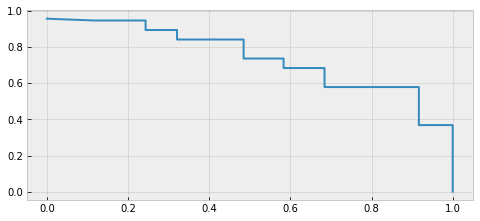

In [36]:
fig, ax = plt.subplots(figsize=(8, 3.5), nrows=1, ncols=1)
ax.plot(mpre, mrec)
plt.show()